# Mobile Price Classification

Dataset: https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

In [2]:
data = pd.read_csv("../data/train.csv")

### Basic data analysis

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

__• battery_power__ - Total energy a battery can store in one time measured in mAh

__• blue__ - Has bluetooth or not

__• clock_speed__ - speed at which microprocessor executes instructions

__• dual_sim__ - Has dual sim support or not

__• fc__ - Front Camera mega pixels

__• four_g__ - Has 4G or not

__• int_memory__ - Internal Memory in Gigabytes

__• m_dep__ - Mobile Depth in cm

__• mobile_wt__ - Weight of mobile phone

__• n_cores__ - Number of cores of processor

__• pc__ - Primary Camera mega pixels

__• px_height__ - Pixel Resolution Height

__• px_width__ - Pixel Resolution Width

__• ram__ - Random Access Memory in Mega Bytes

__• sc_h__ - Screen Height of mobile in cm

__• sc_w__ - Screen Width of mobile in cm

__• talk_time__ - longest time that a single battery charge will last when you are

__• three_g__ - Has 3G or not

__• touch_screen__ - Has touch screen or not

__• wifi__ - Has wifi or not

__• price_range__ - This is the target variable with value of 0(low cost), 1(medium cost), 2(high cost) and 3(very high cost).

In [4]:
data.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [5]:
data.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,...,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,...,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,...,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,...,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,...,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,...,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,...,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


### Price range column analysis

In [6]:
data['price_range'].unique()

array([1, 2, 3, 0], dtype=int64)

In [7]:
print(data['price_range'].value_counts())

1    500
2    500
3    500
0    500
Name: price_range, dtype: int64


<AxesSubplot: ylabel='price_range'>

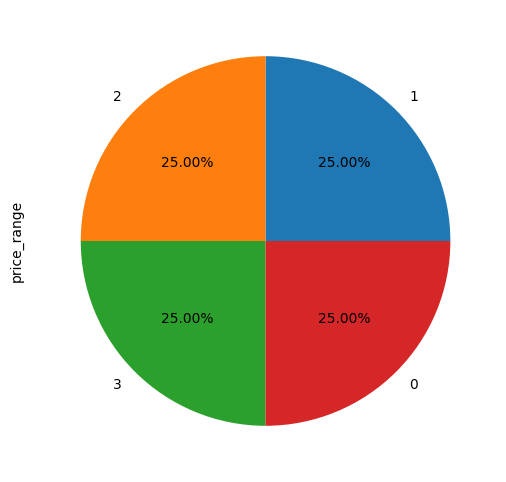

In [8]:
plt.figure(figsize=(10,6))
data['price_range'].value_counts().plot.pie(autopct='%.2f%%')

### Visual analysis

<AxesSubplot: >

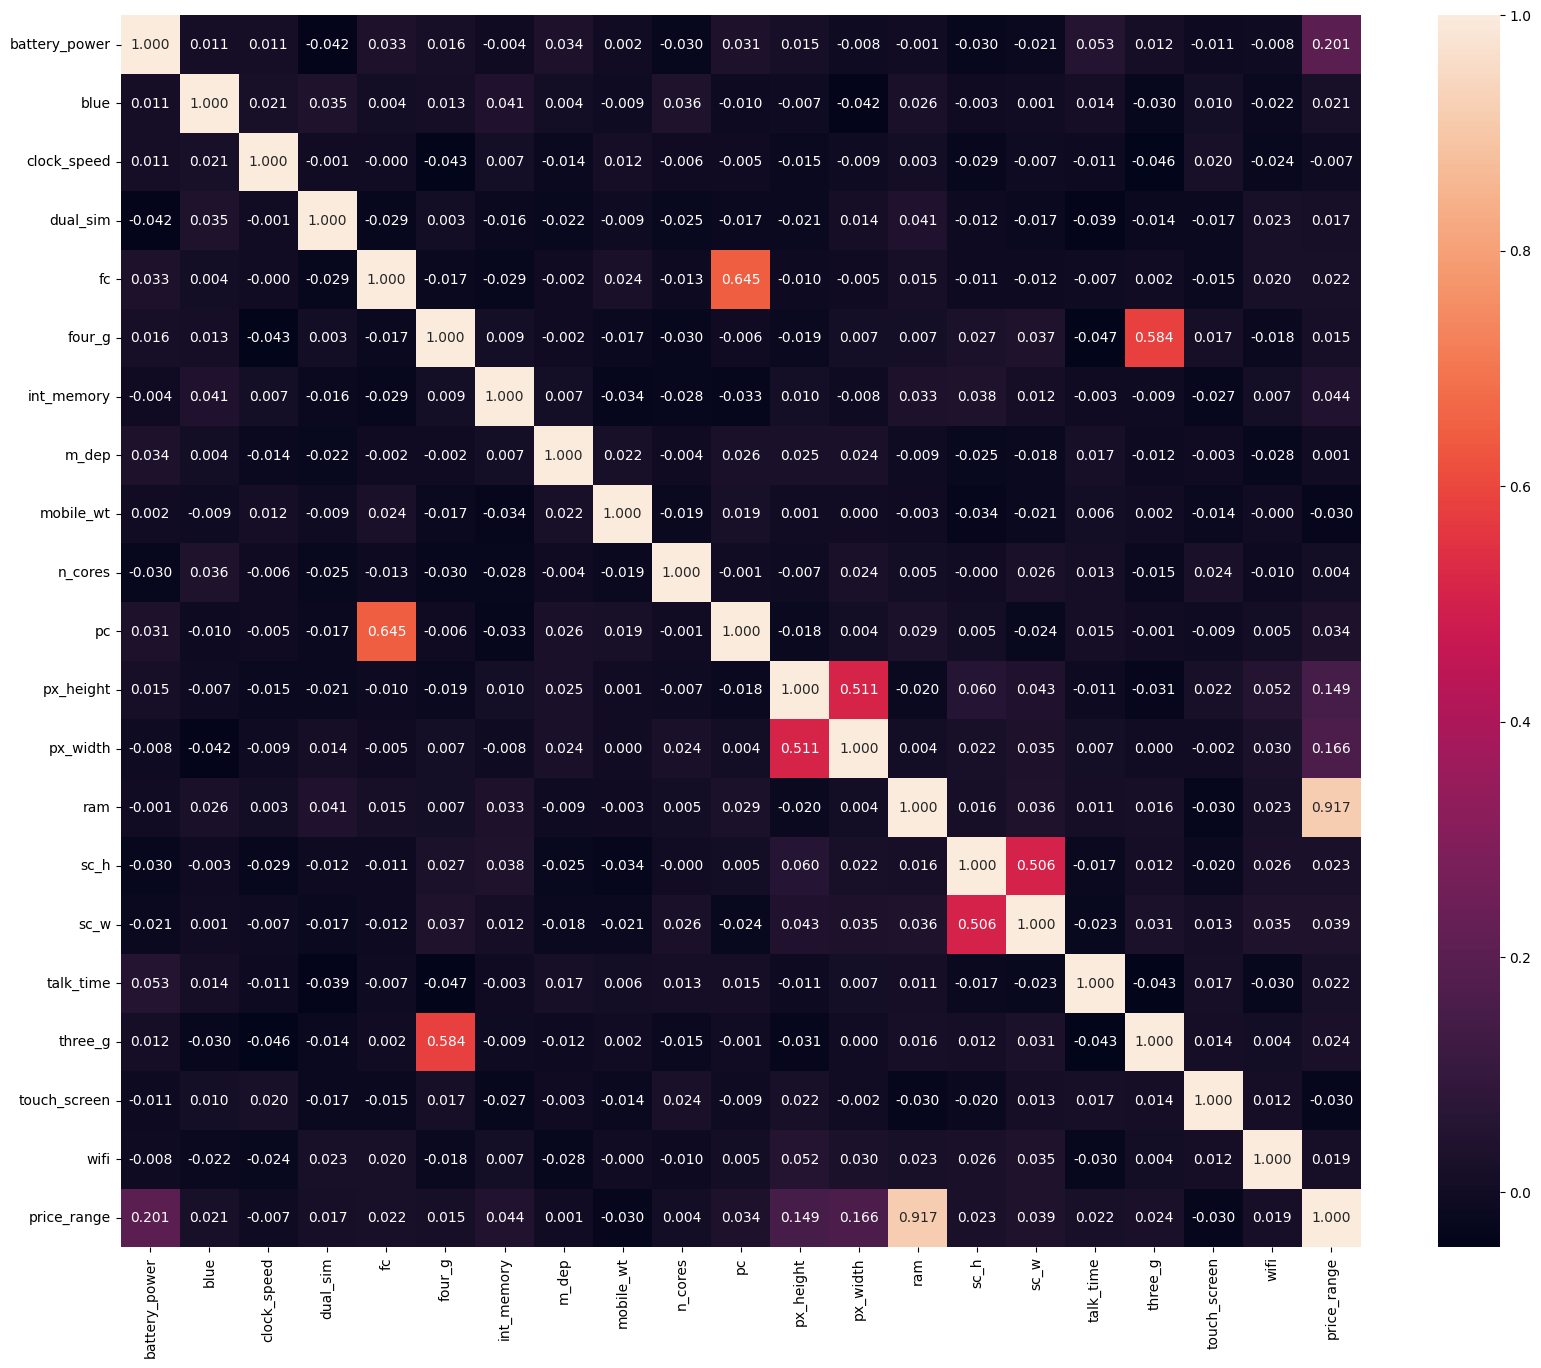

In [9]:
fig, ax = plt.subplots(figsize = (20, 16))
sns.heatmap(data.corr(), ax = ax, annot = True, fmt = ".3f")

<AxesSubplot: xlabel='price_range', ylabel='ram'>

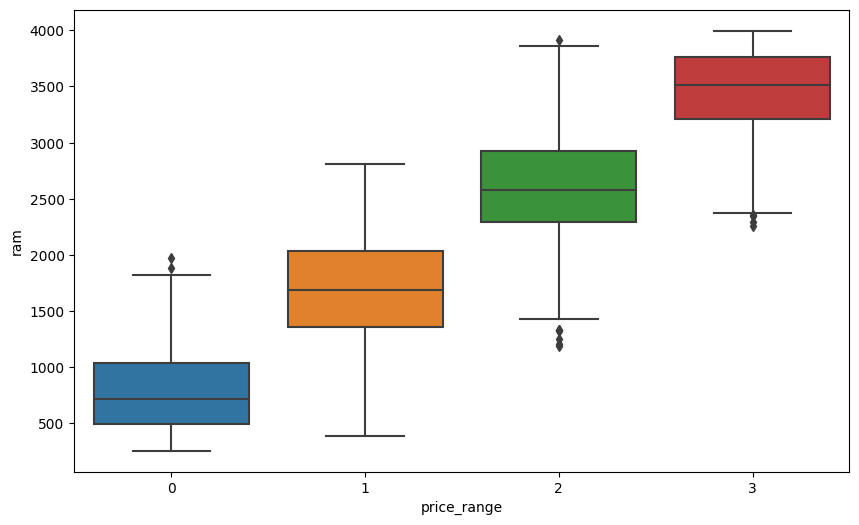

In [10]:
plt.figure(figsize=(10,6))
sns.boxplot(y=data['ram'],x=data['price_range'])

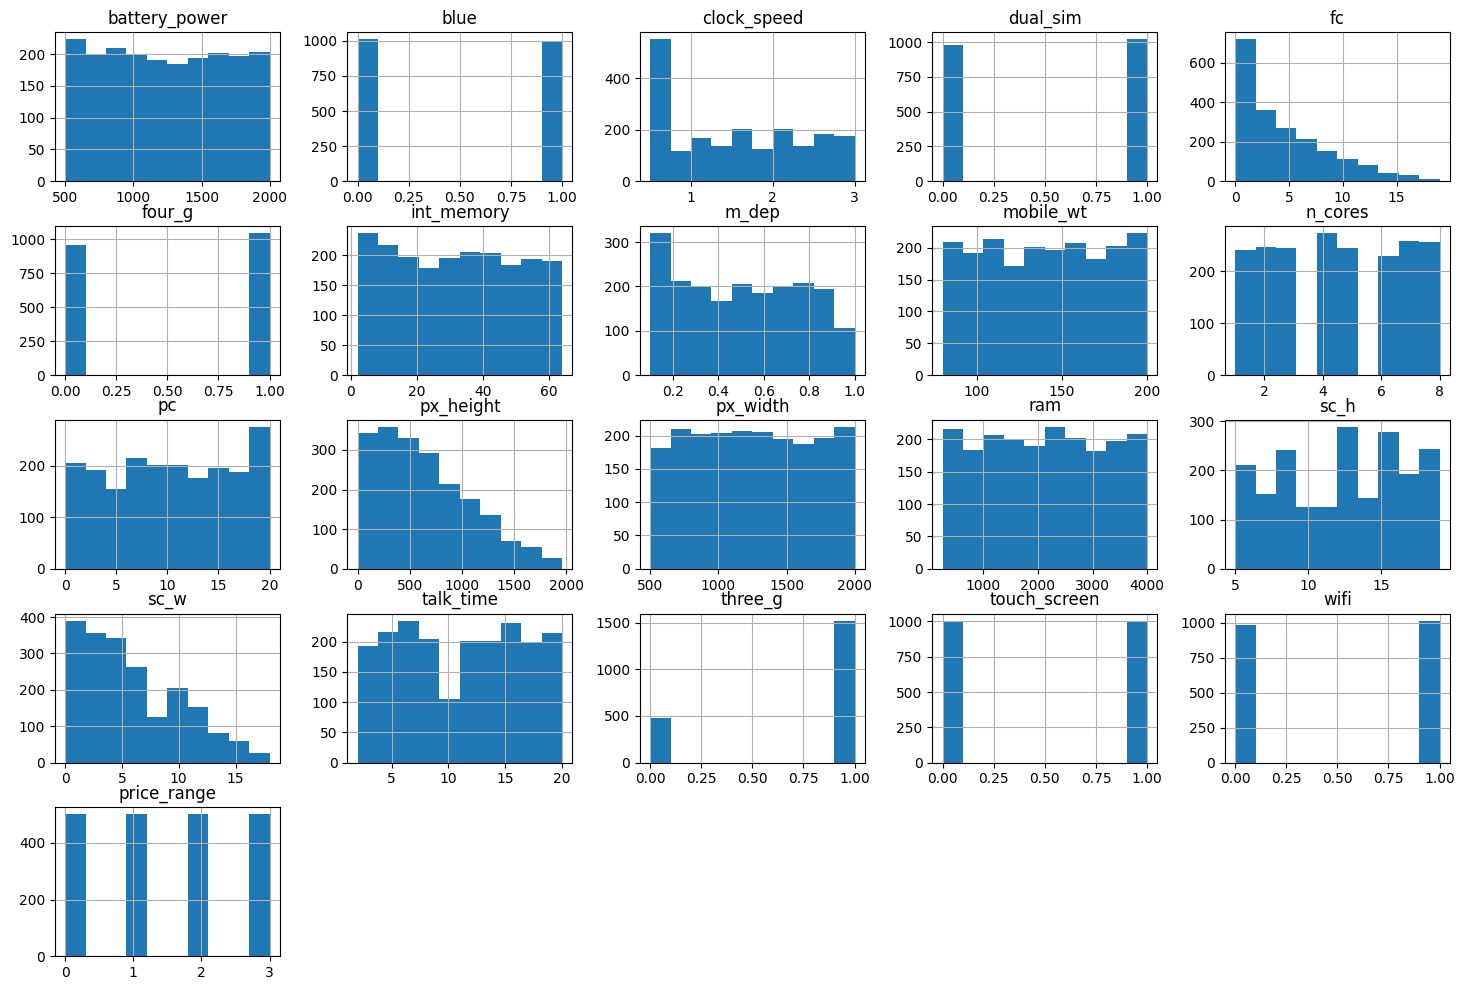

In [11]:
data_hist = data.hist(figsize=(18,12))

In [12]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

dataset = pd.read_csv("../data/train.csv")

# for column in dataset.columns[:-1]:
for column in dataset.columns:
    dataset[column] = NormalizeData(dataset[column])

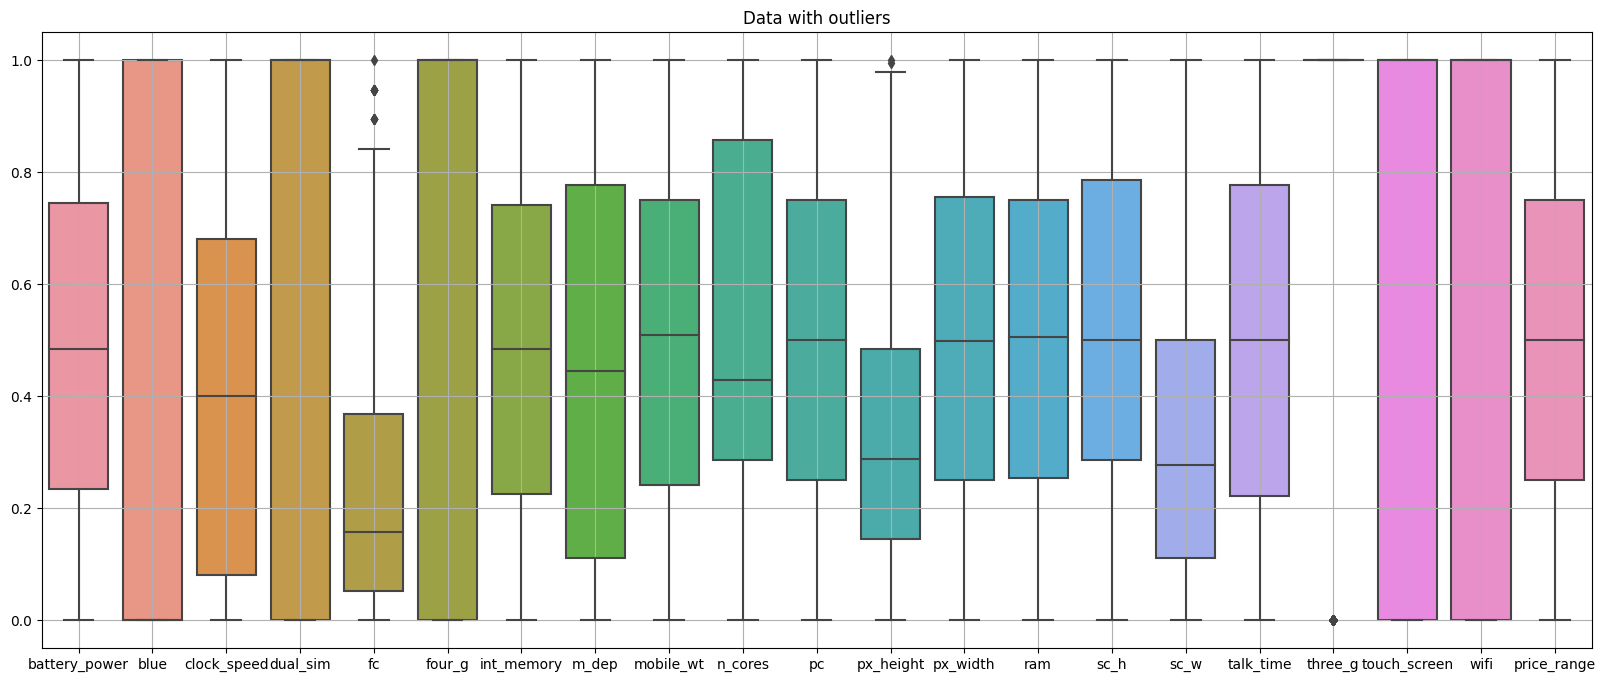

In [13]:
plt.figure(figsize=(20,8))
plt.title("Data with outliers")
sns.boxplot(data = dataset)
plt.grid()
plt.show()

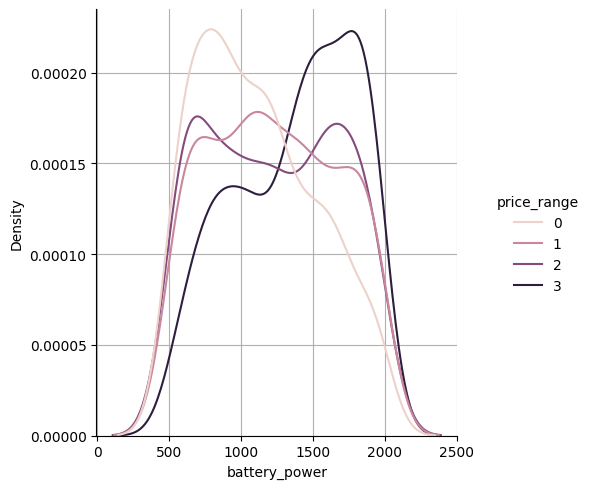

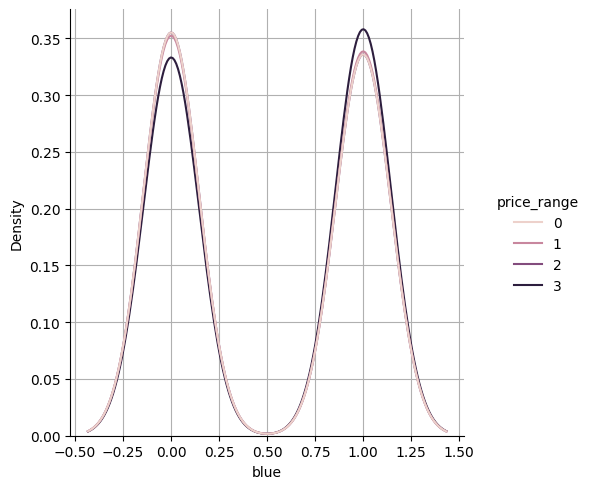

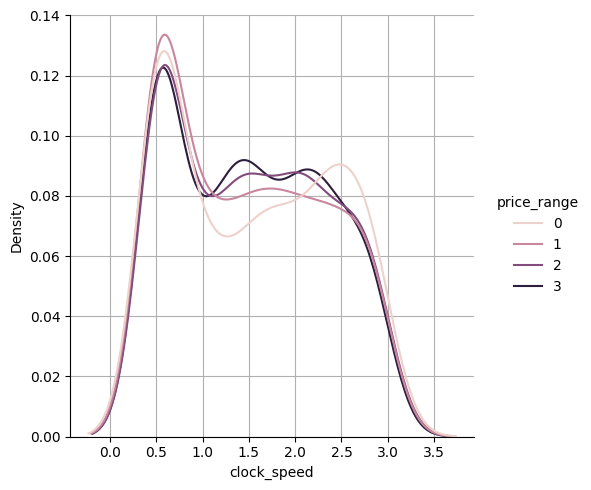

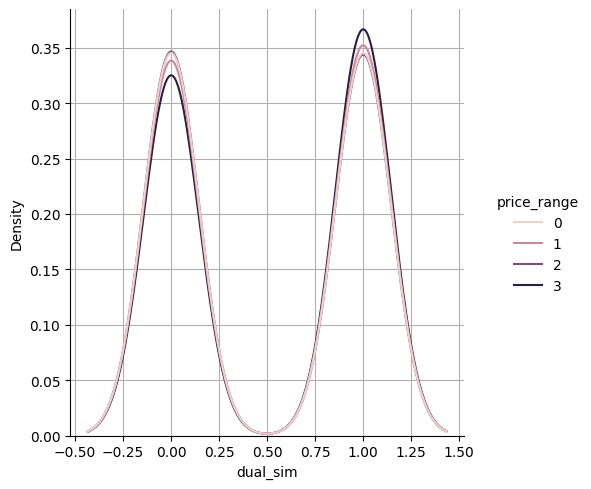

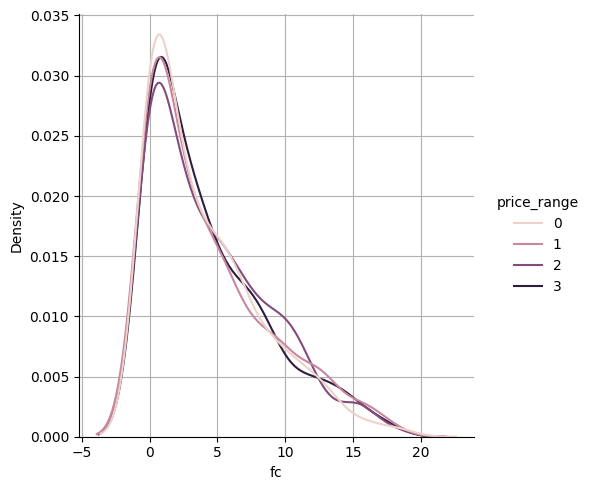

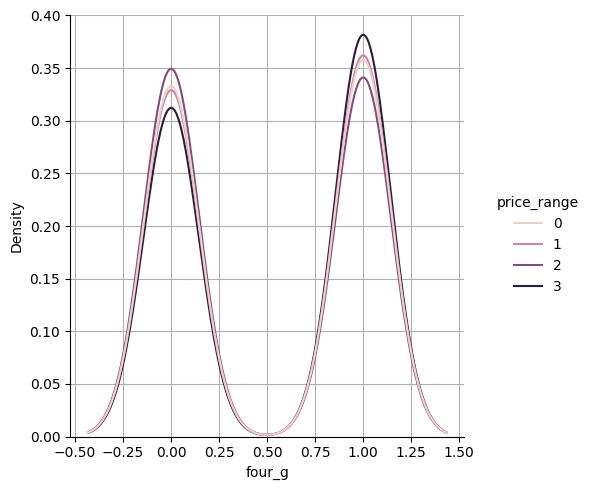

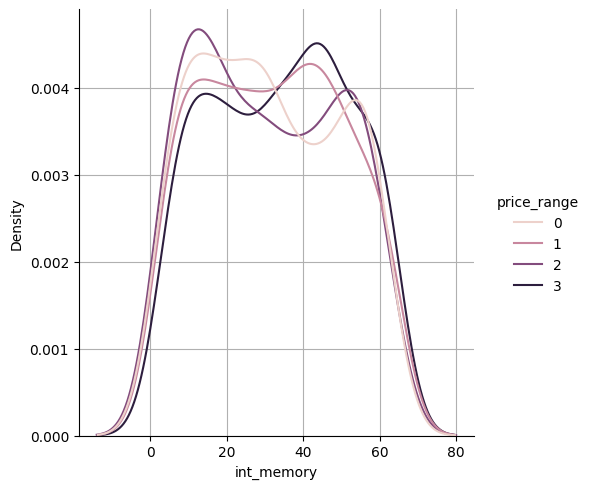

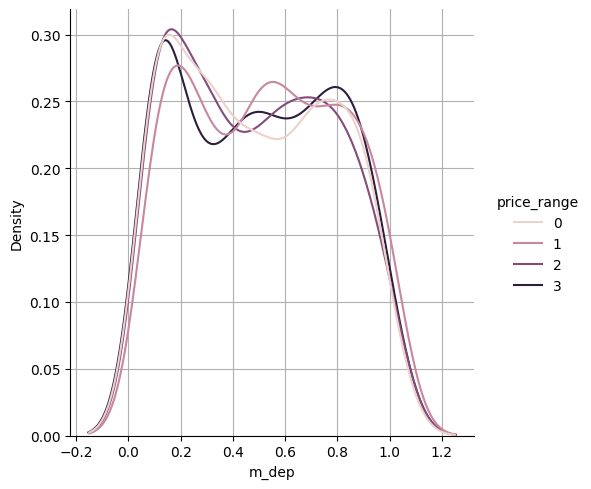

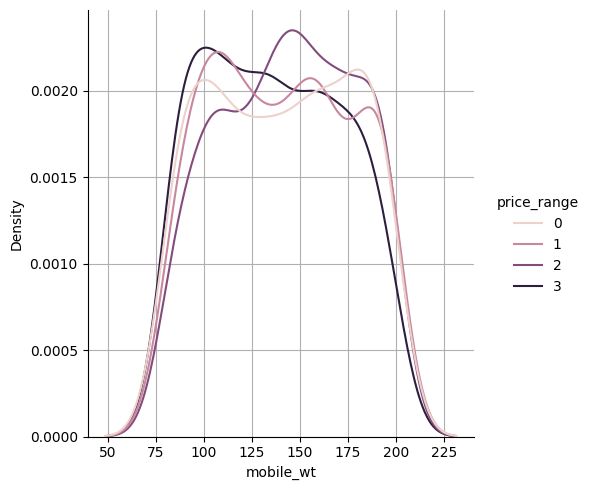

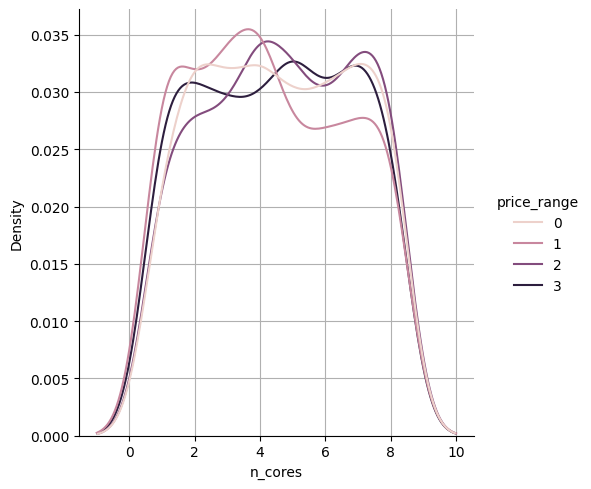

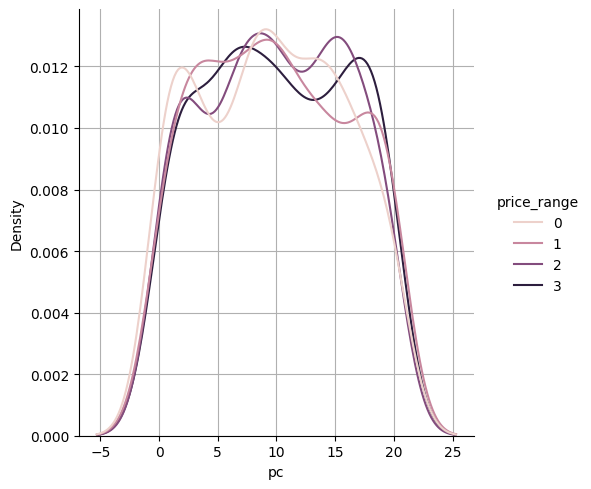

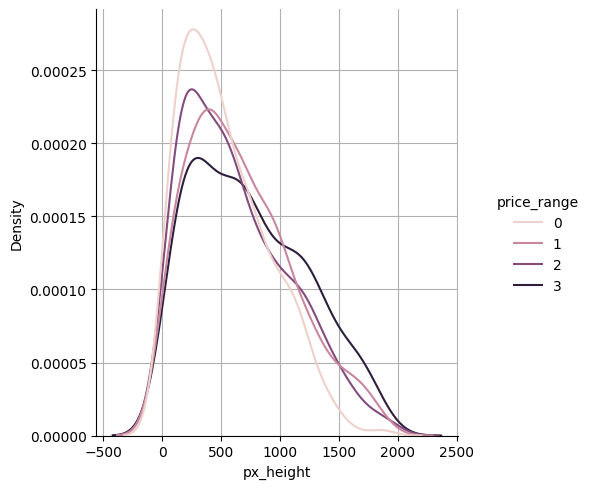

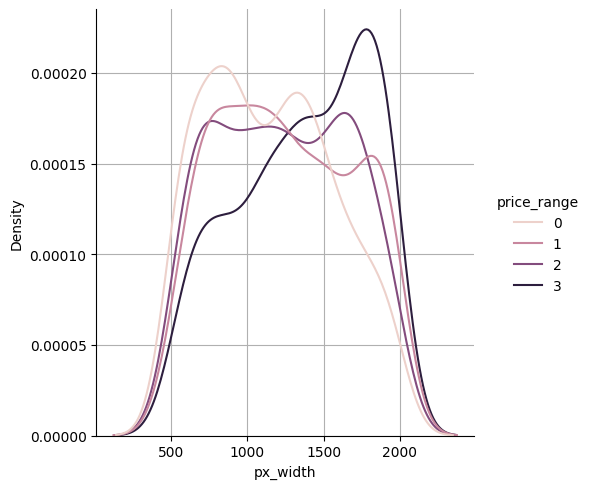

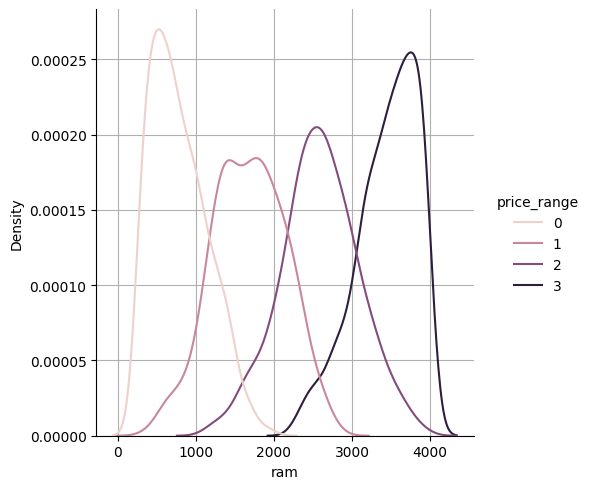

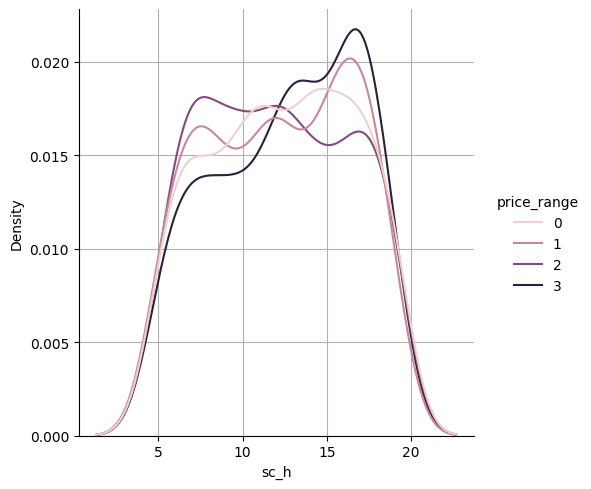

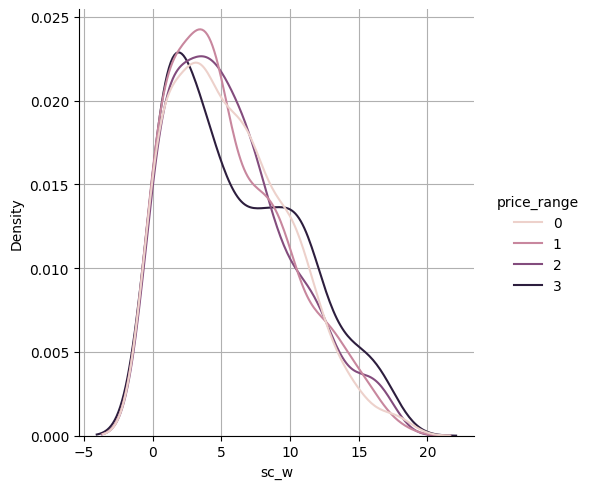

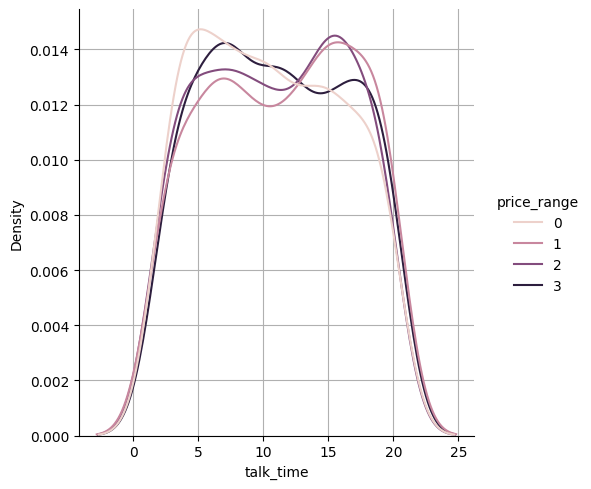

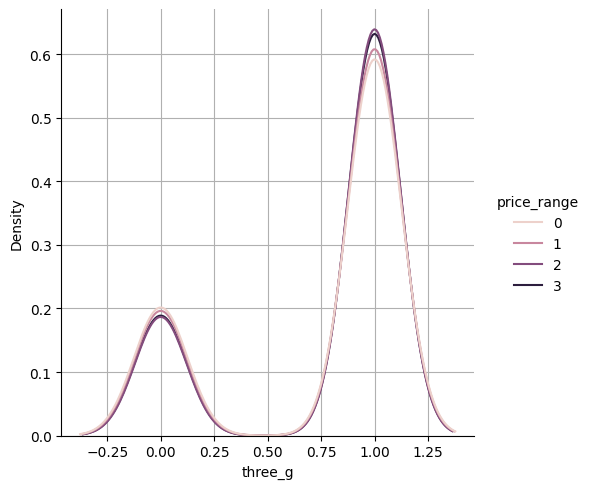

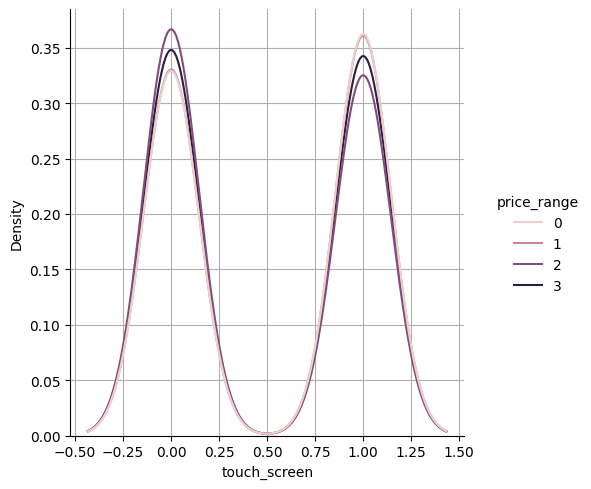

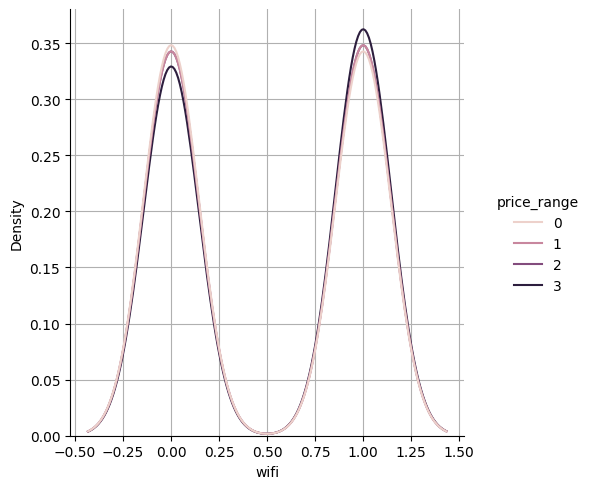

In [14]:
for colm in data.select_dtypes(np.number).columns[:-1]:
    sns.displot(data, x = colm,  hue="price_range", kind="kde", fill=False)
    plt.grid()
    plt.show()

In [15]:
input_data = dataset.drop('price_range', axis=1)

In [16]:
# # split the data 
# dataset = pd.read_csv("../data/train.csv")

# for column in dataset.columns[:-1]:
#     dataset[column] = NormalizeData(dataset[column])

# X_train, X_test, y_train, y_test = train_test_split(input_data, dataset['price_range'], test_size=0.15, random_state=42)

In [17]:
# split the data 
# 70:15:15
dataset = pd.read_csv("../data/train.csv")

for column in dataset.columns[:-1]:
    dataset[column] = NormalizeData(dataset[column])

X_train, X_test, y_train, y_test = train_test_split(input_data, dataset['price_range'], test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.175, random_state=1) # 0.175 x 0.85 .= 0.15

### Tensorflow model

In [ ]:
# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(20,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

# Make predictions
predictions = model.predict(X_test)
print('Predictions:', np.argmax(predictions, axis=1))

Epoch 1/100
44/44 [==============================] - 1s 6ms/step - loss: 1.2676 - accuracy: 0.4194 - val_loss: 1.0474 - val_accuracy: 0.5805
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 0.7777 - accuracy: 0.7111 - val_loss: 0.5654 - val_accuracy: 0.7785
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss: 0.4686 - accuracy: 0.8217 - val_loss: 0.4225 - val_accuracy: 0.8255
Epoch 4/100
44/44 [==============================] - 0s 3ms/step - loss: 0.3585 - accuracy: 0.8673 - val_loss: 0.4024 - val_accuracy: 0.8087
Epoch 5/100
44/44 [==============================] - 0s 3ms/step - loss: 0.2848 - accuracy: 0.8859 - val_loss: 0.2742 - val_accuracy: 0.8859
Epoch 6/100
44/44 [==============================] - 0s 3ms/step - loss: 0.2299 - accuracy: 0.9180 - val_loss: 0.3113 - val_accuracy: 0.8624
Epoch 7/100
44/44 [==============================] - 0s 2ms/step - loss: 0.1858 - accuracy: 0.9365 - val_loss: 0.2192 - val_accuracy: 0.9262
Epoch 8/100
4

Epoch 59/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2565 - val_accuracy: 0.9161
Epoch 60/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.2347 - val_accuracy: 0.9128
Epoch 61/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.2320 - val_accuracy: 0.9128
Epoch 62/100
44/44 [==============================] - 0s 3ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2333 - val_accuracy: 0.9195
Epoch 63/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2341 - val_accuracy: 0.9128
Epoch 64/100
44/44 [==============================] - 0s 3ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2287 - val_accuracy: 0.9128
Epoch 65/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2364 - val_accuracy: 0.9161
Epoch 

In [19]:
# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation='relu', input_shape=(20,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

# Make predictions
predictions = model.predict(X_test)
print('Predictions:', np.argmax(predictions, axis=1))

Epoch 1/100
44/44 [==============================] - 1s 7ms/step - loss: 1.2533 - accuracy: 0.4087 - val_loss: 1.0132 - val_accuracy: 0.5733
Epoch 2/100
44/44 [==============================] - 0s 3ms/step - loss: 0.8184 - accuracy: 0.6434 - val_loss: 0.6314 - val_accuracy: 0.7433
Epoch 3/100
44/44 [==============================] - 0s 3ms/step - loss: 0.5487 - accuracy: 0.7589 - val_loss: 0.5091 - val_accuracy: 0.7500
Epoch 4/100
44/44 [==============================] - 0s 3ms/step - loss: 0.4349 - accuracy: 0.8260 - val_loss: 0.4393 - val_accuracy: 0.8067
Epoch 5/100
44/44 [==============================] - 0s 3ms/step - loss: 0.3450 - accuracy: 0.8531 - val_loss: 0.4494 - val_accuracy: 0.7500
Epoch 6/100
44/44 [==============================] - 0s 3ms/step - loss: 0.3233 - accuracy: 0.8602 - val_loss: 0.3260 - val_accuracy: 0.8700
Epoch 7/100
44/44 [==============================] - 0s 3ms/step - loss: 0.2785 - accuracy: 0.8859 - val_loss: 0.3872 - val_accuracy: 0.8200
Epoch 8/100
4

Epoch 59/100
44/44 [==============================] - 0s 3ms/step - loss: 0.0231 - accuracy: 0.9964 - val_loss: 0.3519 - val_accuracy: 0.8967
Epoch 60/100
44/44 [==============================] - 0s 3ms/step - loss: 0.0146 - accuracy: 0.9971 - val_loss: 0.3814 - val_accuracy: 0.8800
Epoch 61/100
44/44 [==============================] - 0s 3ms/step - loss: 0.0110 - accuracy: 0.9993 - val_loss: 0.3648 - val_accuracy: 0.8933
Epoch 62/100
44/44 [==============================] - 0s 3ms/step - loss: 0.0082 - accuracy: 0.9993 - val_loss: 0.3345 - val_accuracy: 0.9033
Epoch 63/100
44/44 [==============================] - 0s 3ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.3155 - val_accuracy: 0.9000
Epoch 64/100
44/44 [==============================] - 0s 3ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.3503 - val_accuracy: 0.9000
Epoch 65/100
44/44 [==============================] - 0s 3ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.3099 - val_accuracy: 0.8933
Epoch 

### PyTorch model

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(20, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 4)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.softmax(x)
        return x

# Create an instance of the model
model = Net()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.to_numpy()).float()
y_train_tensor = torch.tensor(y_train.to_numpy()).long()
X_test_tensor = torch.tensor(X_test.to_numpy()).float()
y_test_tensor = torch.tensor(y_test.to_numpy()).long()

# Train the model
for epoch in range(100):
    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Print statistics every 10 epochs
    if epoch % 10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))

# Evaluate the model
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    total = y_test_tensor.size(0)
    correct = (predicted == y_test_tensor).sum().item()
    test_acc = correct / total
    print('Test accuracy: {:.2f}%'.format(test_acc * 100))

# Make predictions
with torch.no_grad():
    outputs = model(X_test_tensor[:])
    _, predicted = torch.max(outputs.data, 1)
    print('Predictions:', predicted)

Epoch [1/100], Loss: 1.3860
Epoch [11/100], Loss: 1.3718
Epoch [21/100], Loss: 1.3139
Epoch [31/100], Loss: 1.1881
Epoch [41/100], Loss: 1.0485
Epoch [51/100], Loss: 0.9465
Epoch [61/100], Loss: 0.8875
Epoch [71/100], Loss: 0.8510
Epoch [81/100], Loss: 0.8290
Epoch [91/100], Loss: 0.8141
Test accuracy: 92.00%
Predictions: tensor([0, 1, 1, 0, 3, 2, 0, 2, 2, 3, 0, 3, 1, 1, 3, 0, 0, 1, 1, 1, 3, 3, 1, 2,
        3, 2, 2, 3, 2, 2, 2, 1, 3, 0, 3, 3, 0, 0, 0, 1, 2, 1, 2, 1, 0, 1, 2, 2,
        1, 2, 1, 3, 1, 3, 1, 3, 1, 3, 3, 1, 0, 2, 0, 3, 2, 1, 1, 2, 3, 2, 1, 2,
        0, 3, 3, 1, 2, 1, 1, 0, 0, 3, 1, 2, 3, 2, 2, 0, 1, 1, 3, 0, 1, 1, 2, 3,
        3, 0, 3, 3, 3, 3, 0, 1, 2, 0, 0, 1, 0, 2, 0, 3, 1, 1, 2, 2, 3, 1, 2, 1,
        2, 0, 0, 0, 3, 0, 1, 1, 0, 1, 0, 2, 0, 3, 3, 0, 3, 2, 2, 1, 0, 0, 3, 1,
        0, 3, 0, 0, 0, 1, 3, 3, 1, 1, 0, 2, 1, 0, 3, 1, 3, 1, 3, 2, 3, 1, 2, 2,
        3, 2, 2, 0, 2, 2, 0, 3, 3, 0, 0, 3, 0, 3, 0, 0, 2, 3, 3, 1, 2, 1, 2, 3,
        2, 2, 0, 1, 2, 3, 3, 1, 3, 2